*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.3
IPython 6.2.1

torch 0.3.0.post4


# Model Zoo -- Using PyTorch Dataset Loading Utilities for Custom Datasets (Face Images from CelebA)

This notebook provides an example for how to load an image dataset, stored as individual JPEG files, using PyTorch's data loading utilities. For a more in-depth discussion, please see the official

- [Data Loading and Processing Tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
- [torch.utils.data](http://pytorch.org/docs/master/data.html) API documentation

In this example, we are using the CelebA face image dataset, which is available at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. To execute the following examples, you need to download the "img_align_celeba.zip" (1.34 GB) file from the website and unzip in the current directory where this notebook is located. Similarly, download the attribute list "list_attr_celeba.txt" (25.48 MB) into this directory.


First, let's load the attribute list using Pandas. Here, we will be focussing on one attribute only, gender, which is stored in the "Male" column, where female face images are labeled as -1, and male images are labeled as 1. Further, we are binarizing these labels to 0's and 1's. The JPEG file names associated with each image are stored in the index of the following data frame:

In [2]:
import pandas as pd
import numpy as np


df = pd.read_csv('list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male'])

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df.loc[df['Male'] == -1, 'Male'] = 0

df.head()

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0


## Preprocesing the Dataset

Next, we divide the dataset into 80% train and 20% testing data, and we save the file names and corresponding labels as separate text files:

In [3]:
num_train_examples = int(df.shape[0]*0.8)
df_train = df.iloc[:num_train_examples, :]
df_test = df.iloc[num_train_examples:, :]

df_train.to_csv('celeba_gender_attr_train.txt', sep=" ")
df_test.to_csv('celeba_gender_attr_test.txt', sep=" ")

Note that the images in CelebA are not ordered by gender, thus we do not have to worry about shuffling the dataset. Just as a quick sanity check, let's print the number of labels in the training and test datasets:

In [4]:
print('Number of male and female images in training dataset:')
np.bincount(df_train['Male'].values)

Number of male and female images in training dataset:


array([94093, 67986])

In [5]:
print('Number of male and female images in test dataset:')
np.bincount(df_test['Male'].values)

Number of male and female images in test dataset:


array([24072, 16448])

Let's also check that the text files load correctly using pandas `read_csv` function:

In [6]:
pd.read_csv("celeba_gender_attr_train.txt", nrows=3, sep=" ", index_col=0)

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1


Finally, let's open one of the images to make sure they look ok:

(218, 178, 3)


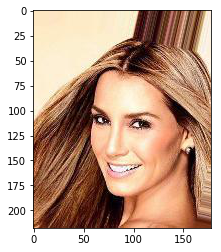

In [7]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import imageio


img = imageio.imread('img_align_celeba/000001.jpg')
print(img.shape)
plt.imshow(img);

## Implementing a Custom Dataset Class

Now, we implement a custom `Dataset` for reading the images. The `__getitem__` method will

1. read a single image from disk based on an `index` (more on batching later)
2. perform a custom image transformation (if a `transform` argument is provided in the `__init__` construtor)
3. return a single image and it's corresponding label

In [8]:
from torch.utils.data import Dataset
import torch


class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path, sep=" ", index_col=0)
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = imageio.imread(os.path.join(self.img_dir,
                                          self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

Now that we have created our custom Dataset class, let us add some custom transformations via the `transforms` utilities from `torchvision`, we

1. normalize the images (here: dividing by 255)
2. converting the image arrays into PyTorch tensors

Then, we initialize a Dataset instance for the training images using the 'celeba_gender_attr_train.txt' label file (we omit the test set, but the same concepts apply).

Finally, we initialize a `DataLoader` that allows us to read from the dataset.

In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms


custom_transform = transforms.Compose([transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(txt_path='celeba_gender_attr_train.txt',
                              img_dir='img_align_celeba/',
                              transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4) 

That's it, now we can iterate over an epoch using the train_loader as an iterator and use the features and labels from the training dataset for model training:

## Iterating Through the Custom Dataset

In [10]:
from torch.autograd import Variable

torch.manual_seed(0)
num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):

        x, y = Variable(x), Variable(y)
        if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda()

        # do model training on x and y here
        break

Just to make sure that the batches are being loaded correctly, let's print out the dimensions of the last batch:

In [11]:
x.shape

torch.Size([128, 3, 218, 178])

As we can see, each batch consists of 128 images, just as specified. However, one thing to keep in mind though is that
PyTorch uses a different image layout (which is more efficient when working with CUDA); here, the image axes are "num_images x channels x height x width" (NCHW) instead of "num_images height x width x channels" (NHWC):

To visually check that the images that coming of the data loader are intact, let's swap the axes to NHWC and convert an image from a Torch Variable to a NumPy array so that we can visualize the image via `imshow`:

In [12]:
one_image = x[0].permute(1, 2, 0).data.numpy()
one_image.shape

(218, 178, 3)

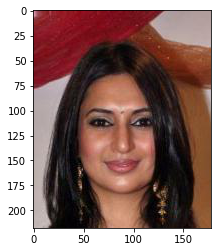

In [13]:
# note that we previously scaled the images
# via 1/255., hence the rescaling
plt.imshow(one_image * 255.);